In [3]:

# from polytropic_stars.EOSPath import EOSPath
from EOSGenerator import EOSGenerator
import matplotlib.pyplot as plt
import random
from CRUST import CRUST
import numpy as np
from scipy.integrate import solve_ivp
import random
import csv
import os 
from EOS import EOS
# TOV right-hand side equations

# TOV right-hand side equations
def tov_rhs(r, z, eos_object, P_saturation):
    M, P = z

    if P <= 0:
        return [0, 0]

    if P > P_saturation:
        epsilon = eos_object.energy_density_from_pressure(P)

    elif 0.184 <= P <= P_saturation:
        e = EOS(P)
        epsilon = e.HLPS_2()

    else:
        crust = CRUST(P)
        epsilon = crust.equation()

    dM_dr = 11.2e-6 * r**2 * epsilon
    dP_dr = -1.474 * (epsilon * M / r**2) * (1 + P / epsilon) * (1 + 11.2e-6 * r**3 * P / M) * (1 - 2.948 * M / r)**(-1)

    return [dM_dr, dP_dr]


# Stopping event when pressure becomes tiny
def stop_when_pressure_small(r, y):
    return y[1] - 1e-10  # Stop when P ~ 0
stop_when_pressure_small.terminal = True
stop_when_pressure_small.direction = -1

# Solve a single TOV star
def solve_star(P_central, eos_object):
    
    z0 = [1e-12, P_central]  # Initial [M, P]
    r_span = (1e-9, 2e6)     # Integrate from tiny radius up to big radius
    sol = solve_ivp(lambda r, z: tov_rhs(r, z, eos_object, 1.722),
                    r_span, 
                    z0,
                    method='RK45',
                    atol=1e-10,
                    rtol=1e-8,
                    events=[stop_when_pressure_small],
                    max_step=0.1)
    return sol

# Process one EOS model
def process_model(model_name, eos_object, initial_pressures):
    results = []

    for i, P_center in enumerate(initial_pressures):
        sol = solve_star(P_center, eos_object)

        if sol.status == 1:  # event triggered (good convergence)
            R_star = sol.t_events[0][0]  # surface radius
            M_star = sol.y_events[0][0][0]  # final mass
            results.append((M_star, R_star, P_center))
            print(f"Model:{model_name} | Mass:{M_star:.4f} | Radius:{R_star:.4f} | Pc={P_center:.2f}")
        else:
            print(f"Warning: Model {model_name} Pc={P_center:.2f} did not converge.")

    return model_name, results

# MAIN EXECUTION
if __name__ == "__main__":
    # Create folder for results
    os.makedirs('TOV_results', exist_ok=True)

    # Generate EOS models
    p_sat = 1.722  # MeV/fm³
    e = EOS(p_sat)
    initial_rho = e.HLPS_2()  # fm⁻³
    segments = 4
    gamma_options = [1, 5]

    generator = EOSGenerator(p_saturation=p_sat, initial_density=initial_rho, segments=segments, gamma_options=gamma_options)
    generator.generate()
    eos_models = generator.get_models()

    # Define central pressures
    ic1 = np.arange(1.5, 5, 0.1)
    ic2 = np.arange(5, 1200, 1)
    initial_pressures = np.concatenate((ic1, ic2), axis=None)

    # Solve for all EOS models
    for eos_model in eos_models:
        model_name = eos_model.name
        eos_object = eos_model

        model_name, model_results = process_model(model_name, eos_object, initial_pressures)

        # Save results
    with open(f"TOV_results/{model_name}_TOV.csv", "w", newline="") as f:
        write_obj = csv.writer(f)
        write_obj.writerow(["Mass", "Radius", "Pressure", "Type"])
        for m, r, p in model_results:
            write_obj.writerow([m, r, p, 0])

Model:EOS_0 | Mass:0.7217 | Radius:2375.8676 | Pc=1.50
Model:EOS_0 | Mass:0.2124 | Radius:2262.3662 | Pc=1.60
Model:EOS_0 | Mass:0.0595 | Radius:142.0360 | Pc=1.70
Model:EOS_0 | Mass:0.0620 | Radius:66.4639 | Pc=1.80
Model:EOS_0 | Mass:0.0651 | Radius:44.9093 | Pc=1.90
Model:EOS_0 | Mass:0.0682 | Radius:34.8975 | Pc=2.00
Model:EOS_0 | Mass:0.0713 | Radius:29.4048 | Pc=2.10
Model:EOS_0 | Mass:0.0740 | Radius:26.1162 | Pc=2.20
Model:EOS_0 | Mass:0.0764 | Radius:23.9282 | Pc=2.30
Model:EOS_0 | Mass:0.0785 | Radius:22.3435 | Pc=2.40
Model:EOS_0 | Mass:0.0805 | Radius:21.1523 | Pc=2.50
Model:EOS_0 | Mass:0.0822 | Radius:20.1899 | Pc=2.60
Model:EOS_0 | Mass:0.0838 | Radius:19.4747 | Pc=2.70
Model:EOS_0 | Mass:0.0852 | Radius:18.8527 | Pc=2.80
Model:EOS_0 | Mass:0.0865 | Radius:18.3386 | Pc=2.90
Model:EOS_0 | Mass:0.0877 | Radius:17.8936 | Pc=3.00
Model:EOS_0 | Mass:0.0887 | Radius:17.5129 | Pc=3.10
Model:EOS_0 | Mass:0.0897 | Radius:17.1765 | Pc=3.20
Model:EOS_0 | Mass:0.0906 | Radius:16.891

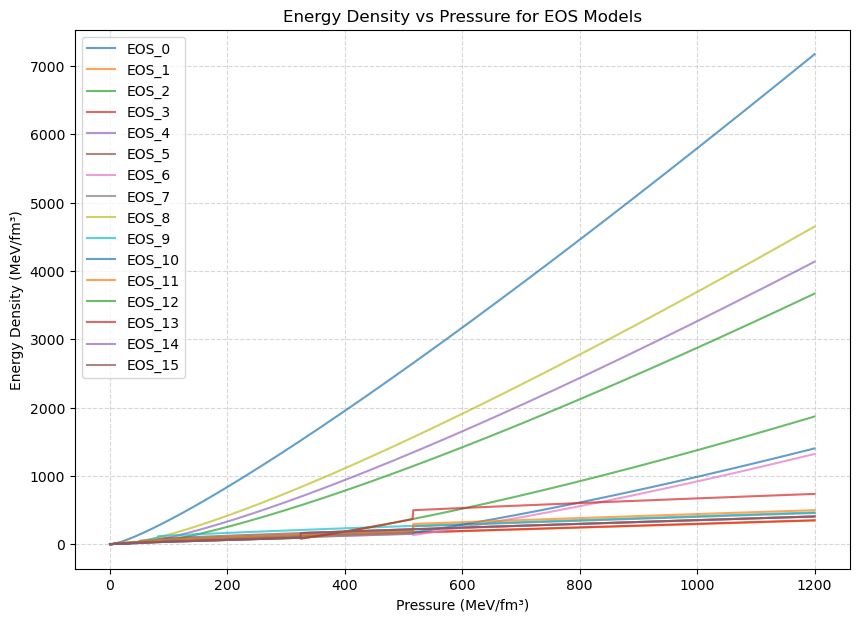

In [ ]:
plt.figure(figsize=(10, 7))

# Plot HLPS_2 EOS
plt.plot(p, e1, label="HLPS_2", linewidth=2)

# Plot energy_density_from_pressure for each model
for model in eos_models:
    energy_density = [model.energy_density_from_pressure(pressure) for pressure in p]
    plt.plot(p, energy_density, label=model.name, alpha=0.7)

plt.xlabel("Pressure (MeV/fm³)")
plt.ylabel("Energy Density (MeV/fm³)")
plt.title("Energy Density vs Pressure for EOS Models")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


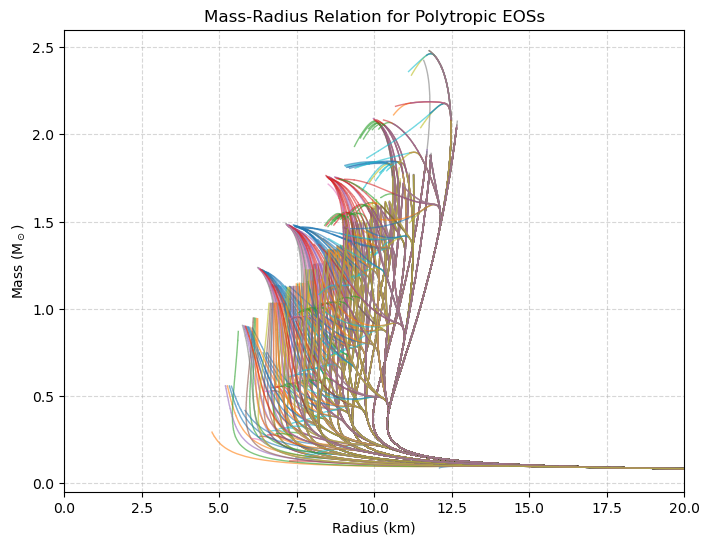

In [1]:
import matplotlib.pyplot as plt
import csv
import glob

files = glob.glob("polytropic_main/TOV_results/*TOV.csv")

plt.figure(figsize=(8,6))
for file in files:
    masses, radii = [], []
    with open(file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            mass_km = float(row['Mass'])
            radius_km = float(row['Radius'])
            mass_Msun = mass_km 
            masses.append(mass_Msun)
            radii.append(radius_km)
    plt.plot(radii, masses, alpha=0.6, lw=1)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.title("Mass-Radius Relation for Polytropic EOSs")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.xlim(0, 20)
plt.show()


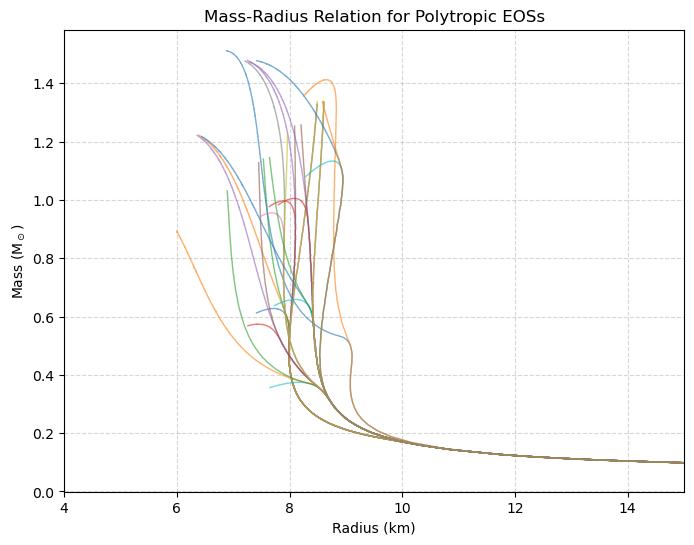

In [31]:
import matplotlib.pyplot as plt
import csv
import glob

files = glob.glob("polytropic_main/TOV_results/*TOV.csv")

plt.figure(figsize=(8,6))
for file in files[:32]:
    masses, radii = [], []
    with open(file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            mass_km = float(row['Mass'])
            radius_km = float(row['Radius'])
            mass_Msun = mass_km 
            masses.append(mass_Msun)
            radii.append(radius_km)
    plt.plot(radii, masses, alpha=0.6, lw=1)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.title("Mass-Radius Relation for Polytropic EOSs")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.xlim(4, 15)
plt.show()


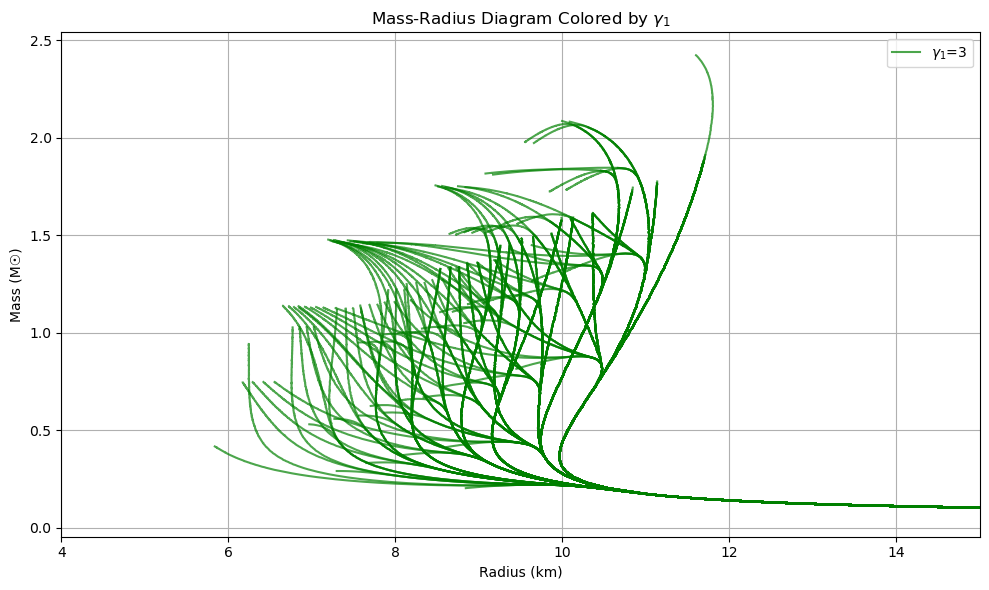

In [27]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ---- Configuration ----

# Define gamma_1 values and corresponding colors
gamma_colors = {
    1: 'blue',
    3: 'green',
    5: 'red'
}

# Path to TOV result CSVs
results_folder = "TOV_results"

# Extract gamma_1 values from filenames (you can also use a mapping file if needed)
def get_gamma1_from_filename(filename):
    # Assume filename pattern: EOS_<index>_TOV.csv
    # You must manually map index to gamma_1 or hardcode it if you don't recompute
    index = int(filename.split("_")[1])
    # This mapping must match how your models were generated in the original script
    gamma_options = [1, 3, 5]
    segments = 6
    from itertools import product
    all_gamma_paths = list(product(gamma_options, repeat=segments))
    gamma_1 = all_gamma_paths[index - 1][0]  # Subtract 1 because EOS_1 is index 0
    return gamma_1

# ---- Plotting ----

plt.figure(figsize=(10, 6))
plotted_labels = set()

for filepath in sorted(glob.glob("polytropic_main/TOV_results/*TOV.csv")):
    filename = os.path.basename(filepath)
    gamma_1 = get_gamma1_from_filename(filename)
    color = gamma_colors.get(gamma_1, 'black')

    data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
    if data.ndim != 2 or data.shape[0] == 0:
        continue
    M_vals = data[:, 0]
    R_vals = data[:, 1]

    label = f"$\gamma_1$={gamma_1}" if gamma_1 not in plotted_labels else None
    if label:
        plotted_labels.add(gamma_1)
    
    if gamma_1 == 3:
    
        plt.plot(R_vals, M_vals, color=color, alpha=0.7, label=label)

# ---- Labels and Legend ----

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M☉)")
plt.title("Mass-Radius Diagram Colored by $\\gamma_1$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "MR_diagram_by_gamma1.png"))
plt.xlim(4,15)
plt.show()


In [11]:
get_gamma1_from_filename(file[10])

ValueError: invalid literal for int() with base 10: ''

In [ ]:
import pandas as pd 
# List all CSV files in the TOV_results directory
files = glob.glob("polytropic_main/TOV_results/*TOV.csv")  
maxs = []
for file in files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    maxs.append(df['Pressure'].max())
# Find the maximum pressure across all files
max_pressure = max(maxs)
print(f"Maximum pressure across all EOS models: {max_pressure:.2f} MeV/fm³")
    

Maximum pressure across all EOS models: 1520.00 MeV/fm³


In [20]:
print("Maximum pressure across all EOS models:", maxs)

Maximum pressure across all EOS models: [193.0, 1516.0, 363.0, 379.0, 1344.0, 306.0, 252.0, 252.0, 256.0, 98.0, 50.0, 774.0, 429.0, 193.0, 1516.0, 362.0, 379.0, 1330.0, 303.0, 193.0, 1516.0, 395.0, 367.0, 379.0, 1358.0, 308.0, 254.0, 255.0, 256.0, 379.0, 1403.0, 317.0, 498.0, 742.0, 933.0, 265.0, 212.0, 213.0, 215.0, 193.0, 1516.0, 372.0, 379.0, 98.0, 1381.0, 313.0, 258.0, 258.0, 261.0, 379.0, 1430.0, 322.0, 742.0, 951.0, 774.0, 270.0, 216.0, 216.0, 224.0, 178.0, 178.0, 179.0, 178.0, 179.0, 179.0, 420.0, 179.0, 179.0, 193.0, 98.0, 774.0, 433.0, 193.0, 1516.0, 365.0, 379.0, 193.0, 1341.0, 306.0, 193.0, 1516.0, 369.0, 379.0, 1370.0, 310.0, 256.0, 256.0, 1516.0, 256.0, 379.0, 1414.0, 317.0, 742.0, 941.0, 265.0, 214.0, 214.0, 215.0, 353.0, 193.0, 1516.0, 375.0, 379.0, 1395.0, 315.0, 260.0, 260.0, 261.0, 379.0, 98.0, 25.0, 1443.0, 324.0, 742.0, 961.0, 270.0, 218.0, 218.0, 224.0, 180.0, 180.0, 774.0, 183.0, 180.0, 181.0, 188.0, 180.0, 182.0, 193.0, 379.0, 1489.0, 331.0, 423.0, 742.0, 993.0, 

In [21]:
maxs

[193.0,
 1516.0,
 363.0,
 379.0,
 1344.0,
 306.0,
 252.0,
 252.0,
 256.0,
 98.0,
 50.0,
 774.0,
 429.0,
 193.0,
 1516.0,
 362.0,
 379.0,
 1330.0,
 303.0,
 193.0,
 1516.0,
 395.0,
 367.0,
 379.0,
 1358.0,
 308.0,
 254.0,
 255.0,
 256.0,
 379.0,
 1403.0,
 317.0,
 498.0,
 742.0,
 933.0,
 265.0,
 212.0,
 213.0,
 215.0,
 193.0,
 1516.0,
 372.0,
 379.0,
 98.0,
 1381.0,
 313.0,
 258.0,
 258.0,
 261.0,
 379.0,
 1430.0,
 322.0,
 742.0,
 951.0,
 774.0,
 270.0,
 216.0,
 216.0,
 224.0,
 178.0,
 178.0,
 179.0,
 178.0,
 179.0,
 179.0,
 420.0,
 179.0,
 179.0,
 193.0,
 98.0,
 774.0,
 433.0,
 193.0,
 1516.0,
 365.0,
 379.0,
 193.0,
 1341.0,
 306.0,
 193.0,
 1516.0,
 369.0,
 379.0,
 1370.0,
 310.0,
 256.0,
 256.0,
 1516.0,
 256.0,
 379.0,
 1414.0,
 317.0,
 742.0,
 941.0,
 265.0,
 214.0,
 214.0,
 215.0,
 353.0,
 193.0,
 1516.0,
 375.0,
 379.0,
 1395.0,
 315.0,
 260.0,
 260.0,
 261.0,
 379.0,
 98.0,
 25.0,
 1443.0,
 324.0,
 742.0,
 961.0,
 270.0,
 218.0,
 218.0,
 224.0,
 180.0,
 180.0,
 774.0,
 183.0,
 18